# "How Student Demographic Affects SAT Performance in NYC"

> "I combine multiple datasets about NYC high schools to explore the effect of students' demographics on SAT performance. The project ends with a multiple linear regression model showing that the effect of race percentages on average SAT score is significant."

- author: Migs Germar
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, pandas, numpy, matplotlib, seaborn]
- hide: false
- search_exclude: false
- image: images/2021-06-13-test-paper.jfif

<center><img src = "https://miguelahg.github.io/mahg-data-science/images/2021-06-13-test-paper.jfif" alt = "A test paper being answered with a pencil."></center>

<center><a href = "https://unsplash.com/photos/qDgTQOYk6B8">Unsplash | 
Nguyen Dang Hoang Nhu</a></center>

# Overview

The [SAT](https://collegereadiness.collegeboard.org/sat), or Scholastic Assessment Test, is taken by many high school students in the USA and around the world before college applications. SAT scores are one of the kinds of information used by colleges to determine a student's level of college readiness.

However, the SAT has faced controversy due to analyses which have shown that students' demographics - such as sex, race, socio-economic status - may have [influenced their SAT performance](https://www.brookings.edu/research/race-gaps-in-sat-scores-highlight-inequality-and-hinder-upward-mobility/).

Thus, the goal of this project is to determine the ways in which New York City high school students' demographics may affect SAT performance. Towards this end, we have:

- Downloaded various datasets on NYC high schools from [NYC Open Data](https://opendata.cityofnewyork.us/) 
- Cleaned, transformed, and combined these datasets into one DataFrame
- Conducted exploratory data analysis and visualizations
- Performed multiple linear regression

The final regression model explained 71.5% of the variance (R2= 0.715, F(5, 392) = 67.93, p < 0.01). The percentage of each race in a school significantly predicted each school's average SAT score.

> Note: I wrote this notebook for the [Dataquest](https://www.dataquest.io/) course's [Guided Project: Analyzing NYC High School Data](https://app.dataquest.io/m/217/guided-project%3A-analyzing-nyc-high-school-data/6/next-steps). The general project flow and research questions came from Dataquest. However, all of the text and code here are written by me unless stated otherwise.

# Package Installs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import re

# Data Transformation and Cleaning

In this section, we transform some columns in each dataset in order to get useful values. Then, we combine all of the datasets into one DataFrame. Some data cleaning will also be performed throughout the process. This is necessary in order to perform analysis using all of the columns available.

## List of Datasets

The following are the datasets that were downloaded from NYC Open Data for this project. The files were renamed to have shorter names.

- `sat_results.csv`: 2012 SAT results [(link)](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)
- `hs_directory`: 2010 - 2011 School Attendance and Enrollment Statistics by District [(link)](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt)
- `class_size.csv`: 2010-2011 Class Size - School-level detail [(link)](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)
- `ap_2010.csv`: 2010 AP (College Board) School Level Results [(link)](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e)
- `graduation.csv`: 2005-2010 Graduation Outcomes - School Level [(link)](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a)
- `demographics.csv`: 2006 - 2012 School Demographics and Accountability Snapshot [(link)](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j)
- `survey_all.txt`, `survey_d75.txt`: 2011 NYC School Survey [(link)](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8)

The code below reads the CSVs into the program.

In [2]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for filename in data_files:
    key = filename[:-4] # Remove ".csv"
    df = pd.read_csv("./2021-06-13-HSD-Files/" + filename)
    
    # Rename "dbn" to "DBN".
    df = df.rename(
        {"dbn": "DBN"},
        axis = 1,
    )
    
    # Assign the DataFrame to a key in the dictionary.
    data[key] = df

As for the TXT files, these are tab-delimited and encoded using Windows-1252 encoding, so we have to specify that when we read them in. We will also concatenate these two datasets vertically because these have the same column names.

In [3]:
# Survey data on all community schools.
all_survey = pd.read_csv(
    "./2021-06-13-HSD-Files/survey_all.txt",
    delimiter = "\t",
    encoding = "windows-1252",
)

# Survey data on all District 75 schools.
d75_survey = pd.read_csv(
    "./2021-06-13-HSD-Files/survey_d75.txt",
    delimiter = "\t",
    encoding = "windows-1252",
)

# Concatenate the two datasets vertically into one dataset.
survey = pd.concat(
    [all_survey, d75_survey],
    axis = 0,
)

# Rename "dbn" column to "DBN" for consistency.
survey = survey.rename(
    {"dbn": "DBN"},
    axis = 1,
)

# Put the DataFrame into the main dictionary.
data["survey"] = survey

Now, all of the datasets can be accessed via the `data` Series.

In [4]:
data = pd.Series(data)

list(data.index)

['ap_2010',
 'class_size',
 'demographics',
 'graduation',
 'hs_directory',
 'sat_results',
 'survey']

To give an idea of what these datasets look like, we show the first few rows of the SAT results dataset below. 

- Each row contains data on one school.
- Each column provides a different detail about the schools, such as school name, number of test takers in each school, etc.

In [5]:
data.sat_results.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


## SAT Total Scores

The SAT results dataset contains columns showing the average score in each section of the test.

However, there is no column representing the average SAT total score. This is important to know because it gauges a student's overall mastery of high school knowledge and college preparedness.

Thus, we will generate a total score column by taking the sum of the three section score columns.

In [6]:
score_cols = [
    "SAT Math Avg. Score",
    "SAT Critical Reading Avg. Score",
    "SAT Writing Avg. Score",
]

# Convert each column from string to numeric.
for col in score_cols:
    data.sat_results[col] = pd.to_numeric(
        data.sat_results[col],
        errors = "coerce", # Set invalid parsing as NaN.
    )

# Get the total scores by summing the 3 section scores.
data.sat_results["sat_score"] = (
    data.sat_results[score_cols]
    .sum(
        axis = 1,
        skipna = False, # Return NaN if the row has a NaN.
    )
)

# Drop rows with missing values.
data.sat_results.dropna(inplace = True)

data.sat_results[score_cols + ["sat_score"]].head()

,SAT Math Avg. Score,SAT Critical Reading Avg. Score,SAT Writing Avg. Score,sat_score
0,404.0,355.0,363.0,1122.0
1,423.0,383.0,366.0,1172.0
2,402.0,377.0,370.0,1149.0
3,401.0,414.0,359.0,1174.0
4,433.0,390.0,384.0,1207.0


The `sat_score` column now shows each school's average SAT total score.

## School Location

Another piece of information we want to find is the set of geographical coordinates of each NYC school. We can find this using the `hs_directory` dataset, which has a `Location 1` column.

In [7]:
data.hs_directory[["DBN", "school_name", "Location 1"]].head()

,DBN,school_name,Location 1
0,17K548,Brooklyn School for Music & Theatre,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67..."
1,09X543,High School for Violin and Dance,"1110 Boston Road\nBronx, NY 10456\n(40.8276026..."
2,09X327,Comprehensive Model School Project M.S. 327,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241..."
3,02M280,Manhattan Early College School for Advertising,"411 Pearl Street\nNew York, NY 10038\n(40.7106..."
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40..."


Let's inspect the first value in this column to see its format.

In [8]:
print(data.hs_directory.loc[0, "Location 1"])

883 Classon Avenue
Brooklyn, NY 11225
(40.67029890700047, -73.96164787599963)


Each value is a string with three lines. The third line contains the school's latitude and longitude in parentheses.

We can extract the coordinate data using the regular expression `\((.+)\)`. This matches a pair of parentheses containing 1 or more characters between them.

In [9]:
def get_coords(text, which = 0):
    
    """Take a string, extract coordinates, and return one of the values."""
    
    pattern = r"\((.+)\)" # Regex
    extracted = re.findall(pattern, text) # Returns a list of extracted strings
    coords = extracted[0].split(", ") # Split string into list of strings
    
    # Return one of the coordinates as a float64.
    result = np.float64(coords[which])
    return result

# Make latitude and longitude columns.
data.hs_directory["lat"] = (
    data.hs_directory["Location 1"]
    .apply(get_coords, which = 0)
)

data.hs_directory["lon"] = (
    data.hs_directory["Location 1"]
    .apply(get_coords, which = 1)
)

data.hs_directory[["lat", "lon"]].head()

,lat,lon
0,40.670299,-73.961648
1,40.827603,-73.904475
2,40.842414,-73.916162
3,40.710679,-74.000807
4,40.718810,-73.806500


We have successfully extracted the latitude and longitude from each string.

## Survey Dataset Columns

Another issue is that there are too many columns in the `survey` dataset:

In [10]:
data.survey.shape

(1702, 2773)

There are 2773 columns. The reason is that each column represents a different survey item or option. It appears that the survey had many items.

However, if we look at the [data dictionary](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8), we can see that there are only a few very important columns:

In [11]:
important_fields = [
    # Unique DBN of each school
    "DBN",
    
    # Response rates
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    
    # Scores about various aspects of the school experience
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

Thus, we will only keep these columns in `survey` and remove the rest.

In [12]:
data.survey = data.survey[important_fields]

## DBN Column

Earlier, we saw that the first column in the `sat_results` dataset was `DBN`.

In [13]:
data.sat_results.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0


The DBN, or [District Borough Number](https://teachnyc.zendesk.com/hc/en-us/articles/360053601831-What-is-a-DBN-District-Borough-Number-), is a unique code that identifies each school in NYC.

Since it is unique to each school, we can use it to match rows across our datasets and combine them into one. However, the `class_size` dataset doesn't have a DBN column.

In [14]:
data.class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


By comparing the `sat_results` dataset to the `class_size` dataset, we can see that the DBN is actually a combination of:

- the CSD (Community School District), like "01".
- the School Code, like "M015".

The CSD must have two digits, so single-digit CSDs need to be padded with a zero in front. This is done below.

In [15]:
def zero_pad(num):
    
    """Zero-pad a number if it only has 1 digit."""
    
    digits = len(str(num))
    
    if digits == 1:
        zero_padded = str(num).zfill(2)
        return zero_padded
    
    elif digits == 2:
        return str(num)
    
    else:
        raise ValueError("Invalid number of digits.")

data.class_size["padded_csd"] = data.class_size["CSD"].apply(zero_pad)

data.class_size[["CSD", "padded_csd", "SCHOOL CODE"]].head()

,CSD,padded_csd,SCHOOL CODE
0,1,01,M015
1,1,01,M015
2,1,01,M015
3,1,01,M015
4,1,01,M015


Now, we can combine `padded_csd` and `SCHOOL CODE` to make the DBN. 

In [16]:
data.class_size["DBN"] = (
    data.class_size[["padded_csd", "SCHOOL CODE"]]
    .sum(axis = 1) # Add values along rows.
)


# Reorder the df so that DBN is in front.
def reorder_columns(df, first_cols):
    
    """Take a DataFrame and a list of columns. Move those columns to the left side. Return the new DataFrame."""
    
    result = df[
        first_cols
        + [col for col in df if col not in first_cols]
    ]
    
    return result

data.class_size = reorder_columns(data.class_size, ["DBN"])


# Remove padded_csd column
data.class_size.drop(
    "padded_csd",
    axis = 1,
    inplace = True,
)

data.class_size.head()

,DBN,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M015,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,01M015,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,01M015,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,01M015,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,01M015,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


We were successful in creating a `DBN` column for the class size dataset.

## Condensing Datasets

Another issue that needs to be addressed is that some datasets have **multiple rows with the same DBN**. For example, look at the frequency table of DBN values in `class_size`.

In [17]:
data.class_size["DBN"].value_counts()

15K429    57
09X505    56
09X517    56
21K690    52
15K448    52
          ..
24Q290     3
04M964     3
09X090     2
02M267     2
27Q465     2
Name: DBN, Length: 1487, dtype: int64

Each DBN appears at least twice in the dataset. This would be problematic when merging it with other datasets, since each row must have a unique DBN value.

Therefore, we need to **condense** `class_size` and other such datasets so that the DBN value is unique to each row.

The code below identifies which columns need to be condensed based on the frequency of its DBN values.

In [18]:
[
    df_name
    for df_name in data.index
    if data[df_name]["DBN"].value_counts().max() > 1
    
    # Check if any DBN values appear more than once.
]

['ap_2010', 'class_size', 'demographics', 'graduation']

The 4 datasets listed above will be condensed one by one.

### Advanced Placement Dataset

First, the `ap_2010` dataset will be condensed. It contains data on AP (Advanced Placement) test results in 2010.

In [19]:
print(data.ap_2010.shape)

data.ap_2010.head()

(258, 5)


,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39,49,10
1,01M450,EAST SIDE COMMUNITY HS,19,21,s
2,01M515,LOWER EASTSIDE PREP,24,26,24
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255,377,191
4,02M296,High School of Hospitality Management,s,s,s


From the first five rows, it is not immediately clear why DBN values repeat. The DBNs are unique in this sample.

Let's check the frequency table of DBN values.

In [20]:
data.ap_2010["DBN"].value_counts()

04M610    2
28Q440    1
32K556    1
27Q400    1
02M400    1
         ..
02M542    1
02M296    1
05M367    1
26Q495    1
02M425    1
Name: DBN, Length: 257, dtype: int64

This frequency table is ordered by frequency, descending. Thus, we can tell that `04M610` is the only DBN that repeats in this dataset. Let's inspect the 2 rows with this DBN.

In [21]:
data.ap_2010.loc[
    data.ap_2010["DBN"] == "04M610"
]

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
51,04M610,THE YOUNG WOMEN'S LEADERSHIP SCHOOL OF EAST HA...,41,55,29
52,04M610,YOUNG WOMEN'S LEADERSHIP SCH,s,s,s


It looks like the duplication was caused by a simple error in data entry. Row 51 is valid, whereas row 52 has an incomplete school name. It also has a string "s" in numerical columns; this is invalid data.

Thus, we will drop row 52 from the dataset.

In [22]:
data.ap_2010.drop(52, inplace = True)

data.ap_2010["DBN"].value_counts().max()

1

Now that we've dropped the inaccurate row, none of the DBN values repeat.

As a side note, since there were "s" strings in the numerical columns, we realize that these are **object-type** columns. Thus, we have to convert these into numerical columns in order to perform analysis on them later on.

In [23]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    # Convert each column to numerical format.
    data.ap_2010[col] = pd.to_numeric(
        data.ap_2010[col],
        errors = "coerce", # In case of errors, use NaN values.
    )
    
data.ap_2010.dtypes

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object

The numerical columns were successfully converted into `float64` (decimal) format.

### Class Size Dataset

Next, we will condense the `class_size` dataset. It contains aggregated data on the number of students in classes in NYC schools.

Why are there rows with duplicate DBNs? Let's look at the first few rows.

In [24]:
print(data.class_size.shape)

data.class_size.head()

(27611, 17)


,DBN,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M015,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,01M015,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,01M015,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,01M015,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,01M015,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


Look at the `GRADE` and `PROGRAM TYPE` columns. Each school's data is split by grade level, from K to 12. The data are further split by the program type (GEN ED, CTT, etc.). That's why each DBN has multiple rows.

In our case, we are only concerned with high school students' data (grades 9 to 12) since the SAT is taken at this level of education. Let's see which `GRADE` value/s correspond to high school.

In [25]:
data.class_size["GRADE "].value_counts().sort_index()

01          1185
02          1167
03          1143
04          1140
05          1086
06           846
07           778
08           735
09            20
09-12      10644
0K          1237
0K-09       1384
MS Core     4762
Name: GRADE , dtype: int64

Conveniently, there is a `09-12` value. Rows with this value would contain aggregated data on all high school grade levels. Thus, we will filter the `class_size` dataset to keep only these rows.

There is still the issue of the `PROGRAM TYPE` column, however. Let's look at its frequency table.

In [26]:
data.class_size["PROGRAM TYPE"].value_counts()

GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: PROGRAM TYPE, dtype: int64

There are hundreds or thousands of rows under each program type. According to the [data dictionary](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3), the following are the meanings of these values:

- `GEN ED`: General Education
- `CTT`: Collaborative Team Teaching
- `SPEC ED`: Special Education
- `G&T`: Gifted & Talented

The General Education program best represents the majority of high school students, and this is the most frequent program in the data. Thus, we will keep the `GEN ED` rows and drop the rest.

To recap, we chose to filter the dataset to keep rows where the grade level is from 9 to 12 and the program type is General Education. We will do this using the code below.

In [27]:
data.class_size = data.class_size.loc[
    (data.class_size["GRADE "] == "09-12")
    & (data.class_size["PROGRAM TYPE"] == "GEN ED")
]

print(data.class_size.shape)
data.class_size.head()

(6513, 17)


,DBN,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
225,01M292,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN
226,01M292,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN
227,01M292,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN
228,01M292,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN
229,01M292,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN


The first few rows of the dataset show us that we were successful in filtering rows by `GRADE` and `PROGRAM TYPE`. From 27611 rows, we have narrowed the dataset down to 6513 rows.

However, there are still duplicate DBN values. The new problem is that the data are divided by the following columns:

- `CORE SUBJECT (MS CORE and 9-12 ONLY)`
- `CORE COURSE (MS CORE and 9-12 ONLY)`

These columns contain the specific subject or course of the class. We want to get class size data that accounts for all subjects, so we cannot simply filter the dataset by 1 subject.

Instead, we will:

- Group the data by DBN value.
- Aggregate the numerical data by **taking the mean** of each column in each group.

In [28]:
data.class_size = (
    data.class_size
    .groupby("DBN") # Group by the school's unique DBN
    .agg(np.mean) # Aggregate numerical columns using mean
    .reset_index() # Put the DBN column back in the df
)

print(data.class_size.shape)
data.class_size.head()

(583, 8)


,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


The following changes have occurred:

- The dataset now has only 583 rows.
- Only the DBN, CSD, and numerical columns remain.
- The numerical columns contain decimals since the data were aggregated.

Let's check what the **maximum frequency** of DBN values is.

In [29]:
data.class_size["DBN"].value_counts().max()

1

Each DBN only **appears once** in the data. We have condensed the dataset successfully.

### Demographics Dataset

Next, we condense the Demographics dataset. It contains data on NYC high school students' grade level, gender, ethnicity, etc. from 2006 to 2012.

Let's try to identify why each DBN has multiple rows.

In [30]:
print(data.demographics.shape)

data.demographics.head()

(10075, 38)


,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


Based on the `schoolyear` column, each school has a separate row for each academic year. Let's inspect the years available.

In [31]:
data.demographics["schoolyear"].value_counts().sort_index()

20052006    1356
20062007    1386
20072008    1410
20082009    1441
20092010    1475
20102011    1498
20112012    1509
Name: schoolyear, dtype: int64

One of the values represents school year 2011-2012. This is relevant to our analysis because the SAT results dataset is from 2012. Thus, we will filter `demographics` to include only this year.

In [32]:
data.demographics = data.demographics.loc[
    data.demographics["schoolyear"] == 20112012
]

print(data.demographics.shape)
data.demographics.head()

(1509, 38)


,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


Filtering the dataset has reduced it to 1509 rows. Also, if we look at the DBN column, the values appear to be distinct now. Let's check the maximum frequency of its values:

In [33]:
data.demographics["DBN"].value_counts().max()

1

Each DBN value appears only once.

### Graduation Dataset

Lastly, we will condense the graduation dataset. It contains data on the graduation rate in the Cohorts of 2001 to 2006. The cohort of a year is the set of students that entered Grade 9 in that year. Thus, the cohorts in this dataset graduated between 2005 and 2010.

Below are the first five rows of the dataset.

In [34]:
print(data.graduation.shape)

data.graduation.head(5)

(25096, 23)


,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


At first glance, the `Cohort` column appears to be responsible for the duplication of DBNs. Each school has a separate row for each cohort. Below are the cohort values:

In [35]:
data.graduation["Cohort"].value_counts().sort_index()

2001        2637
2002        3095
2003        3432
2004        3708
2005        3963
2006        4130
2006 Aug    4131
Name: Cohort, dtype: int64

As expected, the cohorts range from 2001 to 2006. There also appears to be an extra value representing August of 2006.

Since we can only keep 1 row from each school, it is best to keep the `2006` rows since these are the most recent.

In [36]:
data.graduation = data.graduation.loc[
    data.graduation["Cohort"] == "2006"
]

print(data.graduation.shape)
data.graduation.head()

(4130, 23)


,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


The dataset is left with 4130 rows. Let's check if the DBNs are unique.

In [37]:
data.graduation["DBN"].value_counts().max()

13

It seems that the DBNs still have up to 13 duplicates each.

This may be due to the `Demographic` column. What if it contains values other than "Total Cohort"?

In [38]:
data.graduation["Demographic"].value_counts()

Special Education Students     411
Total Cohort                   405
General Education Students     405
English Proficient Students    401
Female                         396
Male                           395
Hispanic                       395
Black                          394
English Language Learners      340
Asian                          296
White                          292
Name: Demographic, dtype: int64

Indeed, each school has a separate row for each demographic. Since we want to include all or most of the students, we will take the "Total Cohort" rows.

In [39]:
data.graduation = data.graduation.loc[
    data.graduation["Demographic"] == "Total Cohort"
]

print(data.graduation.shape)
data.graduation.head()

(405, 23)


,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


After the dataset was filtered for the second time, it was left with 405 rows.

Let's check the maximum frequency of DBNs again.

In [40]:
data.graduation["DBN"].value_counts().max()

1

The DBNs are now unique to each row in the dataset.

## Column Names

We're almost at the point where we can combine the datasets. However, the final dataset would have many columns. It would be good to be able to know which dataset each column came from. Thus, we will use the following prefix system:

- `A_`: The `ap_2010` dataset
- `C_`: The `class_size` dataset
- `D_`: The `demographics` dataset
- `G_`: The `graduation` dataset
- `H_`: The `hs_directory` dataset
- `R_`: The `sat_results` dataset
- `S_`: The `survey` dataset

I add these prefixes using the code below.

In [41]:
for df_name in data.index:
    # Take the first letter, capitalize it, and append an underscore.
    if df_name == "sat_results":
        prefix = "R_"
    else:
        prefix = df_name[0].upper() + "_"
    
    # Add the prefix to each column label.
    df = data[df_name]
    non_dbn = [col for col in df if col != "DBN"]
    
    dbn_col = df[["DBN"]]
    other_cols = df[non_dbn].add_prefix(prefix)
    
    # Put the df back into the data Series.
    data[df_name] = pd.concat(
        [dbn_col, other_cols],
        axis = 1,
    )

For example, let's see what `ap_2010` looks like now:

In [42]:
data.ap_2010.head()

,DBN,A_SchoolName,A_AP Test Takers,A_Total Exams Taken,A_Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,10.0
1,01M450,EAST SIDE COMMUNITY HS,19.0,21.0,NaN
2,01M515,LOWER EASTSIDE PREP,24.0,26.0,24.0
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,191.0
4,02M296,High School of Hospitality Management,NaN,NaN,NaN


The prefixes were added successfully.

## Combining Datasets

At last, we are ready to combine all of the datasets into one. Datasets be merged on the `DBN` column since this is unique to each row.

We will start with the `sat_results` dataset as the first "left" dataset in the merging process.

We will consider **two ways** to merge datasets:

- Left join: Keep all rows in the "left" dataset, but remove rows in the "right" dataset if their DBNs had no match.
- Inner join: Only keep rows where the DBN exists in both datasets.

Before we choose, though, we will have to find out whether the DBNs in `sat_results` match the ones present in other datasets.

### Heatmap of DBNs

In previous Dataquest guided projects, heatmaps were sometimes used to visualize correlation tables and missing values. I realized that this could be extended to the situation of the DBNs.

What if we created a DataFrame where:

- The columns represent the 7 datasets.
- The indices represent the unique DBNs.
- Each value is `True` if the DBN appears in the specific dataset, else `False`.

Then, we would be able to create a heatmap to visualize which DBNs were present and absent in each dataset.

I wrote the code below in order to make the DataFrame.

In [43]:
col_list = []

for df_name in data.index:
    dbn = data[df_name][["DBN"]] # Get a 1-column DataFrame of DBN values.
    new_col = dbn.set_index("DBN") # Set the DBNs as the indices. There are no columns now.
    new_col[df_name] = 1 # Create a new column of ones.
    
    col_list.append(new_col) # Append the column to the list.

# Combine the columns into one DataFrame.
dbn_grid = pd.concat(
    col_list,
    axis = 1,
).notnull() # Replace values with False if they're null, else True.

dbn_grid.head()

,ap_2010,class_size,demographics,graduation,hs_directory,sat_results,survey
DBN,,,,,,,
01M448,True,True,True,True,True,True,True
01M450,True,True,True,True,True,True,True
01M515,True,True,True,True,False,True,True
01M539,True,True,True,True,True,True,True
02M296,True,True,True,True,True,True,True


Let's take the top left cell as an example. Its value is `True`. This means that the DBN 01M448 appears in the `ap_2010` dataset.

Since SAT performance is our focus, we can filter the rows in the DataFrame to only include the ones where the DBN is present in `sat_results`.

In [44]:
dbn_grid = dbn_grid.loc[
    dbn_grid["sat_results"] # Keep rows where this column contains True values.
]

Now, we can plot our heatmap. Above it, we will also print a table of the exact number of relevant DBNs present in each dataset.

Counts of relevant DBNs in each dataset
ap_2010         251
class_size      401
demographics    412
graduation      381
hs_directory    339
sat_results     421
survey          418
dtype: int64


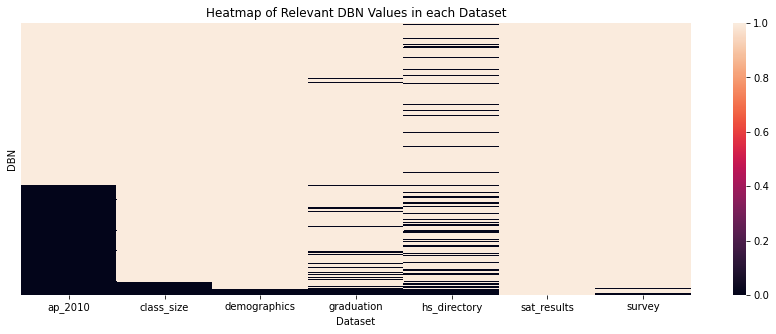

In [45]:
print("Counts of relevant DBNs in each dataset")
print(dbn_grid.sum())

# Initiate the figure
plt.figure(figsize = (15, 5))

# Create a heatmap of the boolean dataframe
sns.heatmap(
    dbn_grid,
    cbar = True, # Include a color bar.
    yticklabels = False, # Do not show y-tick labels.
)

plt.title("Heatmap of Relevant DBN Values in each Dataset")
plt.xlabel("Dataset")
plt.xticks(rotation = 0)
plt.show()

Each column in the heatmap corresponds to one of our 7 datasets. The y-axis represents the unique DBNs.

The DBNs present in a dataset are represented by a light brown color. The missing DBNs are represented by black.

The following can be observed:

- The `sat_results` dataset is complete since we are using it as our basis for which DBNs are "relevant." There are 421 relevant DBNs in total.
- The `ap_2010` dataset has the least DBNs, only 251.
- `hs_directory` and `graduation` have missing DBNs scattered around. They have less than 400 DBNs each.
- `class_size`, `demographics`, and `survey` are the most complete datasets, with over 400 DBNs.

This information will help us in choosing how to merge the datasets.

### Left join

The advantage of performing a left join is apparent when the "right" dataset has **many missing DBN values**.

- With a left join, all of the `sat_results` rows would be kept.
- With an inner join, the number of rows would be significantly reduced.

We saw that `ap_2010`, `hs_directory`, and `graduation` have the most missing DBN values, so these are good candidates for a left join. These 3 datasets provide information that is supplementary but not very crucial to our analysis, so it is fine for some rows to contain missing values.

In [46]:
combined = data.sat_results

for df_name in ["ap_2010", "hs_directory", "graduation"]:
    
    # Merge horizontally.
    combined = combined.merge(
        data[df_name],
        on = "DBN", # Merge on DBN column
        how = "left", # Left join
    )
    
print(combined.shape)
combined.head()

(421, 92)


,DBN,R_SCHOOL NAME,R_Num of SAT Test Takers,R_SAT Critical Reading Avg. Score,R_SAT Math Avg. Score,R_SAT Writing Avg. Score,R_sat_score,A_SchoolName,A_AP Test Takers,A_Total Exams Taken,...,G_Regents w/o Advanced - n,G_Regents w/o Advanced - % of cohort,G_Regents w/o Advanced - % of grads,G_Local - n,G_Local - % of cohort,G_Local - % of grads,G_Still Enrolled - n,G_Still Enrolled - % of cohort,G_Dropped Out - n,G_Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%


The dataset still has all of the data from `sat_results` due to the left join. There are some missing values where the other datasets didn't find a matching DBN.

### Inner join

Inner joins are advantageous when the "right" dataset is **important to analysis**. We would want each row to have complete data from this dataset.

In our case, the remaining datasets to merge are `class_size`, `demographics`, and `survey`. We need the latter two datasets to be complete, since we aim to explore the relationships between student demographics and SAT performance. Thus, we will use an inner join.

In [47]:
for df_name in ["class_size", "demographics", "survey"]:
    
    # Merge horizontally.
    combined = combined.merge(
        data[df_name],
        on = "DBN", # Merge on DBN column
        how = "inner", # Inner join
    )
    
print(combined.shape)
combined.head()

(401, 158)


,DBN,R_SCHOOL NAME,R_Num of SAT Test Takers,R_SAT Critical Reading Avg. Score,R_SAT Math Avg. Score,R_SAT Writing Avg. Score,R_sat_score,A_SchoolName,A_AP Test Takers,A_Total Exams Taken,...,S_eng_t_11,S_aca_t_11,S_saf_s_11,S_com_s_11,S_eng_s_11,S_aca_s_11,S_saf_tot_11,S_com_tot_11,S_eng_tot_11,S_aca_tot_11
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,6.1,6.5,6.0,5.6,6.1,6.7,6.7,6.2,6.6,7.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,6.6,7.3,6.0,5.7,6.3,7.0,6.8,6.3,6.7,7.2
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,8.0,8.8,NaN,NaN,NaN,NaN,7.9,7.9,7.9,8.4
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0,NaN,NaN,NaN,...,8.9,8.9,6.8,6.1,6.1,6.8,7.8,7.1,7.2,7.8
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,6.1,6.8,6.4,5.9,6.4,7.0,6.9,6.2,6.6,7.0


The final `combined` DataFrame has 401 rows (schools) and 158 columns. That's only 20 rows less than what we started with.

## City School Districts

Additionally, we will create a new column containing the city school district (CSD) of each school. The CSD is made up of the **first 2 digits** of a school's DBN.

In [48]:
# Make the new column.
combined["school_dist"] = combined["DBN"].apply(
    lambda text: text[:2] # Get first two characters.
)

# Reorder the columns.
combined = reorder_columns(combined, ["school_dist"])

combined.head()

,school_dist,DBN,R_SCHOOL NAME,R_Num of SAT Test Takers,R_SAT Critical Reading Avg. Score,R_SAT Math Avg. Score,R_SAT Writing Avg. Score,R_sat_score,A_SchoolName,A_AP Test Takers,...,S_eng_t_11,S_aca_t_11,S_saf_s_11,S_com_s_11,S_eng_s_11,S_aca_s_11,S_saf_tot_11,S_com_tot_11,S_eng_tot_11,S_aca_tot_11
0,01,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,...,6.1,6.5,6.0,5.6,6.1,6.7,6.7,6.2,6.6,7.0
1,01,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,...,6.6,7.3,6.0,5.7,6.3,7.0,6.8,6.3,6.7,7.2
2,01,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,...,8.0,8.8,NaN,NaN,NaN,NaN,7.9,7.9,7.9,8.4
3,01,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0,NaN,NaN,...,8.9,8.9,6.8,6.1,6.1,6.8,7.8,7.1,7.2,7.8
4,01,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,...,6.1,6.8,6.4,5.9,6.4,7.0,6.9,6.2,6.6,7.0


The data is now cleaned and ready for analysis.

# Exploratory Data Analysis

## Correlation Coefficients

The goal of this project is to determine how demographic factors affect SAT scores. Thus, we can start our analysis by investigating the Pearson's correlation coefficient between SAT score and each of the other columns.

In [49]:
sat_corr = (
    combined
    .corr()["R_sat_score"] # Take sat_score correlations
    .drop(["R_sat_score"]) # Drop unnecessary variables
    .dropna() # Drop missing values
)

The correlation table has one value for each of the numerical columns in `combined`.

In [50]:
sat_corr.head()

R_SAT Critical Reading Avg. Score    0.976819
R_SAT Math Avg. Score                0.956406
R_SAT Writing Avg. Score             0.981751
A_AP Test Takers                     0.625184
A_Total Exams Taken                  0.614112
Name: R_sat_score, dtype: float64

We'll analyze the data by going through each set of variables based on their original dataset. We'll only use the most important datasets.

Before we do this, we'll define a function that will take a Series and return values whose labels have certain prefixes. This will help us select parts of the correlation table more easily.

In [51]:
def filter_prefix(series, regex):
    
    """Takes a Series and a regex. Returns items in the Series whose labels match the regex at the start."""
    
    result = series[[
        label for label in series.index
        if re.match(regex, label)
    ]]
    return result

For example, we could select all correlations for `ap_2010` and `class_size` variables by filtering prefixes `A` and `C`.

In [52]:
filter_prefix(sat_corr, r"[AC]")

A_AP Test Takers                          0.625184
A_Total Exams Taken                       0.614112
A_Number of Exams with scores 3 4 or 5    0.614752
C_CSD                                     0.054011
C_NUMBER OF STUDENTS / SEATS FILLED       0.400095
C_NUMBER OF SECTIONS                      0.364537
C_AVERAGE CLASS SIZE                      0.395964
C_SIZE OF SMALLEST CLASS                  0.282388
C_SIZE OF LARGEST CLASS                   0.327099
Name: R_sat_score, dtype: float64

Let's proceed to the first set of variables.

## AP Exam Results

First, we'll look at the correlations for `ap_2010` variables. 

In [53]:
filter_prefix(sat_corr, r"[A]")

A_AP Test Takers                          0.625184
A_Total Exams Taken                       0.614112
A_Number of Exams with scores 3 4 or 5    0.614752
Name: R_sat_score, dtype: float64

The number of AP test takers has a positive correlation of 0.63 with SAT score.

Remember that the AP exams are "Advanced Placement" exams taken by USA high schoolers in order to get college credit. Thus, the students who take AP exams tend to have higher academic performance.

Let's make a scatter plot of SAT score against **percentage of AP test takers in each school**.

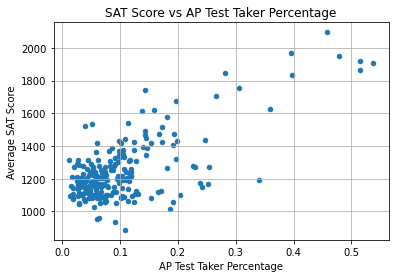

In [54]:
# Make a new column for AP test taker percentage.
combined["A_ap_perc"] = combined["A_AP Test Takers "] / combined["D_total_enrollment"]

# Replace inaccurate data (above 100%) with nulls.
combined["A_ap_perc"] = combined["A_ap_perc"].mask(
    combined["A_ap_perc"] > 1.0,
    np.nan,
)

# Scatter plot
combined.plot.scatter(
    x = "A_ap_perc",
    y = "R_sat_score",
)

plt.title("SAT Score vs AP Test Taker Percentage")
plt.xlabel("AP Test Taker Percentage")
plt.ylabel("Average SAT Score")
plt.grid(True)
plt.show()

The relationship is not linear. We can only observe that:

- Most schools have less than 40% AP takers and less than 1400 SAT points.
- The schools with high SAT scores (above 1600) have less than 60% AP test takers.
- The schools with low SAT scores (under 1400) can have any percentage of AP test takers.

Therefore, it doesn't seem that the percentage of AP test takers in a school reliably influences its average SAT score.

## Survey Data

Let's move on to the `survey` variables.

In [55]:
filter_prefix(sat_corr, r"[S]")

S_rr_s          0.286470
S_rr_t          0.022365
S_rr_p          0.087970
S_N_s           0.438427
S_N_t           0.306520
S_N_p           0.439547
S_saf_p_11      0.111892
S_com_p_11     -0.106899
S_eng_p_11      0.016640
S_aca_p_11      0.026691
S_saf_t_11      0.315796
S_com_t_11      0.097797
S_eng_t_11      0.045746
S_aca_t_11      0.135490
S_saf_s_11      0.286153
S_com_s_11      0.157417
S_eng_s_11      0.174425
S_aca_s_11      0.292592
S_saf_tot_11    0.292468
S_com_tot_11    0.083068
S_eng_tot_11    0.093489
S_aca_tot_11    0.178388
Name: R_sat_score, dtype: float64

The variable names are abbreviated, so it is difficult to understand them. However, the [data dictionary](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) explains their meanings. 

The most important ones are from `S_saf_p_11` downwards. These variables represent scores of 4 aspects of each school:

- Safety and Respect
- Communication
- Engagement
- Academic Expectations

Each aspect has 4 scores based on the respondent group: parents, teachers, students, and total (all groups).

For example, `S_saf_tot_11` refers to the total Safety and Respect score of a school. It had a coefficient of 0.29. Let's see a scatterplot of this.

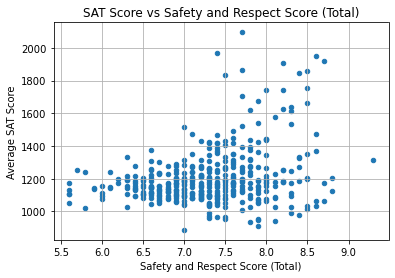

In [56]:
combined.plot.scatter(
    x = "S_saf_tot_11",
    y = "R_sat_score",
)

plt.title("SAT Score vs Safety and Respect Score (Total)")
plt.xlabel("Safety and Respect Score (Total)")
plt.ylabel("Average SAT Score")
plt.grid(True)
plt.show()

The correlation is not strong, as many schools have SAT scores under 1400 regardless of Safety and Respect score.

The schools which did have high scores (above 1500) had safety scores ranging from 7.25 to 8.75. This suggests that having sufficient safety and respect in a school may support the learning experience, though it does not always increase SAT scores.

Another interesting variable would be `S_aca_s_11`, the Academic Expectations score based on student responses. It had a coefficient of 0.29.

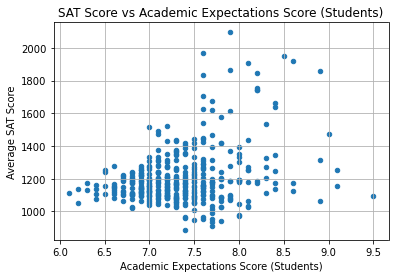

In [57]:
combined.plot.scatter(
    x = "S_aca_s_11",
    y = "R_sat_score",
)

plt.title("SAT Score vs Academic Expectations Score (Students)")
plt.xlabel("Academic Expectations Score (Students)")
plt.ylabel("Average SAT Score")
plt.grid(True)
plt.show()

Again, the correlation is not strong.

It's interesting to note, however, that none of the schools with an Academic Expectations score under 7.5 had SAT scores above 1600. We could say that a school must first have proper academic expectations in order to open the opportunity to excel.

In terms of strong conclusions, though, we can't make any yet.

## Demographics

Lastly, we go to the `demographics` dataset variables. These are the most important variables to investigate for this project.

Here are the correlation coefficients:

In [58]:
filter_prefix(sat_corr, r"[D]")

D_frl_percent        -0.718163
D_total_enrollment    0.385741
D_ell_num            -0.130355
D_ell_percent        -0.379510
D_sped_num            0.058782
D_sped_percent       -0.420646
D_asian_num           0.483939
D_asian_per           0.552204
D_black_num           0.043408
D_black_per          -0.302794
D_hispanic_num        0.052672
D_hispanic_per       -0.363696
D_white_num           0.460505
D_white_per           0.646568
D_male_num            0.345808
D_male_per           -0.107624
D_female_num          0.403581
D_female_per          0.107676
Name: R_sat_score, dtype: float64

The results can be divided into general topics:

- **School size**: The `total_enrollment` has a coefficient of 0.39. This means that bigger schools may have higher SAT scores.
- **English proficiency**: The coefficient for ELL percentage is -0.38.
    - ELL means English Language Learner. It refers to students who are learning as a second or third language because they did not grow up with it.
- **SpEd percentage**: The coefficient for SpEd percentage is -0.42.
    - SpEd means Special Education. It refers to educational plans with special accommodations for students who are disabled or have developmental disorders.
- **Sex**: The following are the coefficients of the percentage of each sex:
    - Male: -0.11
    - Female: 0.11
- **Race**: The following are the coefficients related to the percentage of students belonging to specific races.
    - Asian: 0.55
    - Black: -0.30
    - Hispanic: -0.36
    - White: 0.65
- **Socio-economic status**: The coefficient for FRL percentage -0.72.
    - FRL means Free or Reduced-Price Lunch. This is a program that supports students below a certain income threshold who do not have the means to bring their own lunch to school.
    
We will go through each topic one by one.

### School Size

Below, we plot a scatter plot of SAT scores against the total number of enrollees in each school.

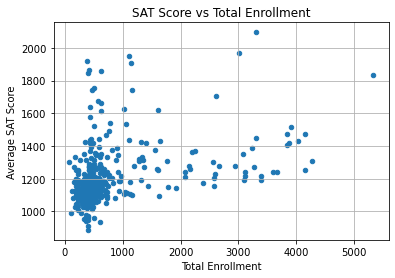

In [59]:
combined.plot.scatter(
    x = "D_total_enrollment",
    y = "R_sat_score",
)

plt.title("SAT Score vs Total Enrollment")
plt.xlabel("Total Enrollment")
plt.ylabel("Average SAT Score")
plt.grid(True)
plt.show()

The scatter plot doesn't have a clear linear trend. Instead, the majority of points are clustered in one area, and the rest of the points are scattered.

Let's inspect the names of the schools at the very bottom left, which have SAT scores under 1000 and total enrollment under 1000.

In [60]:
combined.loc[
    (combined["R_sat_score"] < 1000) & (combined["D_total_enrollment"] < 1000),
    "R_SCHOOL NAME"
]

102                 INTERNATIONAL COMMUNITY HIGH SCHOOL
138                 ACADEMY FOR LANGUAGE AND TECHNOLOGY
139                     BRONX INTERNATIONAL HIGH SCHOOL
153               KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
155               INTERNATIONAL SCHOOL FOR LIBERAL ARTS
197    PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
199                       HIGH SCHOOL OF WORLD CULTURES
210                  BROOKLYN INTERNATIONAL HIGH SCHOOL
241                                 PACIFIC HIGH SCHOOL
251       INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS
266                          IT TAKES A VILLAGE ACADEMY
285                           MULTICULTURAL HIGH SCHOOL
314                ASPIRATIONS DIPLOMA PLUS HIGH SCHOOL
320              PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: R_SCHOOL NAME, dtype: object

Interestingly, the schools with the lowest average SAT scores are mostly small international schools. These schools tend to have more students from different racial and ethnic backgrounds. These students may speak English as a second or third language.

Therefore, the factor that affected SAT performance may have been the percentage of English language learners (ELL) in each school. This makes sense since the SAT is offered only in English and includes sections on Reading and Writing.

### English Proficiency

Let's plot SAT scores against the percentage of ELLs (English Language Learners) in each school.

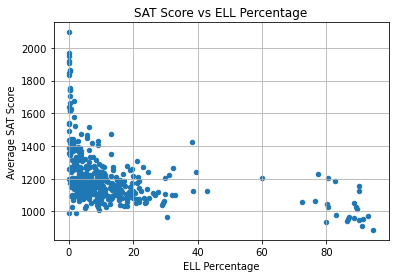

In [61]:
combined.plot.scatter(
    x = "D_ell_percent",
    y = "R_sat_score",
)

plt.title("SAT Score vs ELL Percentage")
plt.xlabel("ELL Percentage")
plt.ylabel("Average SAT Score")
plt.grid(True)
plt.show()

Once again, there isn't a linear trend even though the correlation coefficient between the variables was -0.38. However, we can note that:

- Most schools have less than 50% ELLs and less than 1400 SAT points.
- The schools with the highest SAT scores (over 1500) have almost 0% ELLs.
- All of the schools with over 50% ELLs have very low scores (under 1300).

Therefore, it appears that ELL students are more challenged in reaching high SAT scores.

### SpEd Percentage

The coefficient for SpEd percentage was -0.42, which indicates that schools with more SpEd students may have lower SAT scores. Let's view a scatter plot:

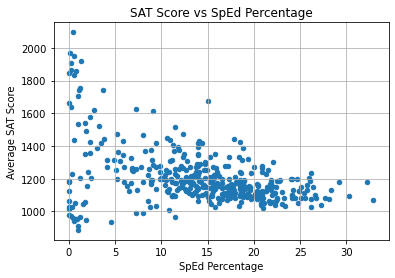

In [62]:
combined.plot.scatter(
    x = "D_sped_percent",
    y = "R_sat_score",
)

plt.title("SAT Score vs SpEd Percentage")
plt.xlabel("SpEd Percentage")
plt.ylabel("Average SAT Score")
plt.grid(True)
plt.show()

The correlation is somewhat linear, but it is not very steep. The points are very scattered, especially on the left side. Interestingly, the schools with an SAT score over 1600 had 15% or less SpEd students.

However, the variable doesn't predict SAT score well.

### Sex

Another factor that's important to investigate is sex. Do schools with more male students or more female students have higher SAT scores?

Earlier, we saw that the male and female percentages had weak correlations with SAT score.

- Male: -0.11; lower SAT scores.
- Female: 0.11; higher SAT scores.

However, these correlations are *weak*, so the difference may not be that great.

Let's use the `female_per` variable in a scatter plot.

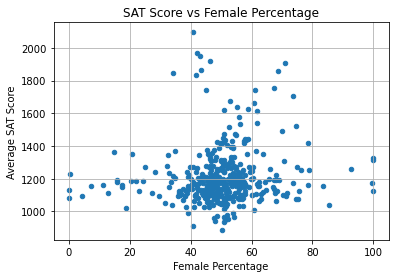

In [63]:
combined.plot.scatter(
    x = "D_female_per",
    y = "R_sat_score",
)

plt.title("SAT Score vs Female Percentage")
plt.xlabel("Female Percentage")
plt.ylabel("Average SAT Score")
plt.grid(True)
plt.show()

As expected, the correlation is weak. We can see that:

- In most schools, 40% to 60% of students are female.
- SAT score is typically below 1400 regardless of female percentage.
- The schools with the highest SAT scores (above 1500) have a 30% to 75% female population.

This variable doesn't seem to be very important to SAT score.

### Race

Earlier, we saw that the following were the coefficients for race percentage variables. Positive values imply that a higher percentage of the given race may lead to higher average SAT score. Negative values: lower score.

- Asian: 0.55
- Black: -0.30
- Hispanic: -0.36
- White: 0.65

Out of all 4, the white percentage value has the strongest correlation, 0.65. This means that having more white students in a school can lead to a higher average SAT score. Let's see a scatterplot of this.

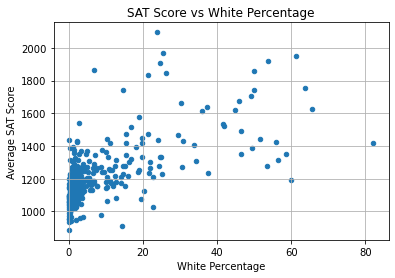

In [64]:
combined.plot.scatter(
    x = "D_white_per",
    y = "R_sat_score",
)

plt.title("SAT Score vs White Percentage")
plt.xlabel("White Percentage")
plt.ylabel("Average SAT Score")
plt.grid(True)
plt.show()

Though the correlation coefficient was stronger than the others, the trend is loose; the points are scattered far away from each other. We can see that:

- Most of the schools in the dataset have SAT scores under 1400 and white percentage under 20%.
- The schools with the highest scores have white percentages ranging from under 10% to over 60%.

Thus, we can't say that a higher white percentage definitely raises the average SAT score.

Since the other race-related variables are weaker than this one, we won't investigate them further. Let's move on to the topic of socio-economic status.

### Socio-economic status

As mentioned earlier, there was a variable representing the percentage of students availing of FRL (Free or Reduced-Price Lunch). Since FRL is for students below an income threshold, we can consider it similar to a **poverty rate**.

The correlation coefficient for this variable is the strongest at -0.72. The FRL students may have lower SAT scores due to external difficulties associated with low socio-economic status which hinder their education.

Below is the scatterplot.

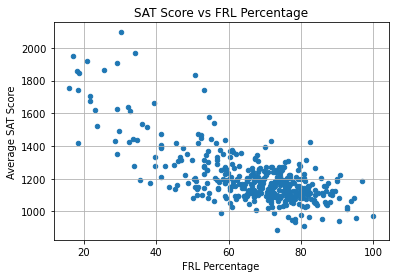

In [65]:
combined.plot.scatter(
    x = "D_frl_percent",
    y = "R_sat_score",
)

plt.title("SAT Score vs FRL Percentage")
plt.xlabel("FRL Percentage")
plt.ylabel("Average SAT Score")
plt.grid(True)
plt.show()

This graph shows a tighter, more linear relationship than was seen in the other graphs.

At the top left of the graph are schools with low FRL percentage and high average SAT score. There are still a few schools with an SAT score over 1600 despite an FRL percentage of over 50%.

However, for the majority of the schools, the FRL percentage is over 60%. All of these schools have an SAT score less than 1500.

Generally, the results suggest that **socio-economic status** is the strongest predictor of average SAT score among all variables in the dataset. **High poverty rate** is associated with a lower average SAT score.

# Inferential Statistics: Linear Regression

As an additional step to this project, we will be performing Ordinary Least Squares linear regression. Some predictors may have a low Pearson's correlation coefficient with the response variable but turn out to be statistically significant when other variables are taken into account.

I used [Linear Regression](https://pythonfordatascienceorg.wordpress.com/linear-regression-python/) by Python for Data Science LLC, along with [(Simple) Linear Regression and OLS: Introduction to the Theory](https://towardsdatascience.com/simple-linear-regression-and-ols-introduction-to-the-theory-1b48f7c69867) (Sluijmers 2020), as my main references.

The dataset has 401 observations. The dependent variable (or response variable) will be each school's average SAT total score, represented by `R_sat_score`.

As for independent variables (or predictor variables), we will start by considering the following.

- English proficiency
    - `D_ell_percent`
- SpEd percentage
    - `D_sped_percent`
- Sex
    - `D_female_per`
    - `D_male_per`
- Race
    - `D_asian_per`
    - `D_black_per`
    - `D_hispanic_per`
    - `D_white_per`
- Socio-economic status
    - `D_frl_percent`.
    
The variable names are placed in the list below.

In [66]:
iv_list = [
    "D_ell_percent",
    "D_sped_percent",
    "D_female_per",
    "D_male_per",
    "D_asian_per",
    "D_black_per",
    "D_hispanic_per",
    "D_white_per",
    "D_frl_percent",
]

I'd like to note that none of these columns have null values, so we don't have to drop any rows or perform imputation.

In [67]:
print("Null values in each column")

combined[iv_list].isnull().sum()

Null values in each column


D_ell_percent     0
D_sped_percent    0
D_female_per      0
D_male_per        0
D_asian_per       0
D_black_per       0
D_hispanic_per    0
D_white_per       0
D_frl_percent     0
dtype: int64

Moving on, the code below creates a matrix `X` for IVs and vector `y` for the DV.

In [68]:
regression_data = (
    combined[["DBN", "R_sat_score"] + iv_list]
    .set_index("DBN")
)

X = regression_data[iv_list].copy()
y = regression_data["R_sat_score"].copy()

regression_data

,R_sat_score,D_ell_percent,D_sped_percent,D_female_per,D_male_per,D_asian_per,D_black_per,D_hispanic_per,D_white_per,D_frl_percent
DBN,,,,,,,,,,
01M292,1122.0,22.3,24.9,38.6,61.4,14.0,29.1,53.8,1.7,88.6
01M448,1172.0,21.1,21.8,42.6,57.4,29.2,22.6,45.9,2.3,71.8
01M450,1149.0,5.0,26.4,45.3,54.7,9.7,23.9,55.4,10.4,71.8
01M458,1174.0,4.0,8.9,56.7,43.3,2.2,34.4,59.4,3.6,72.8
01M509,1207.0,11.2,25.9,53.7,46.3,9.3,31.6,56.9,1.6,80.7
...,...,...,...,...,...,...,...,...,...,...
32K549,1035.0,18.2,18.4,51.6,48.4,0.5,28.3,68.7,1.8,75.1
32K552,1060.0,23.9,22.1,45.5,54.5,1.5,26.4,70.4,1.0,77.1
32K554,1315.0,2.7,4.9,47.9,52.1,5.3,12.9,79.5,1.5,81.4


Before we fit and interpret the model with these DataFrames, we must first test the assumptions of linear regression.

## Assumption 1: Multicollinearity

[Multicollinearity](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/) occurs when multiple predictor variables are highly correlated. Variables with high multicollinearity have unreliable significance values. Thus, this is a problem that must be avoided.

The first way to check for multicollinearity is with a **Pearson's correlation coefficient table**. The code below plots this table using a heatmap for easier interpretation.

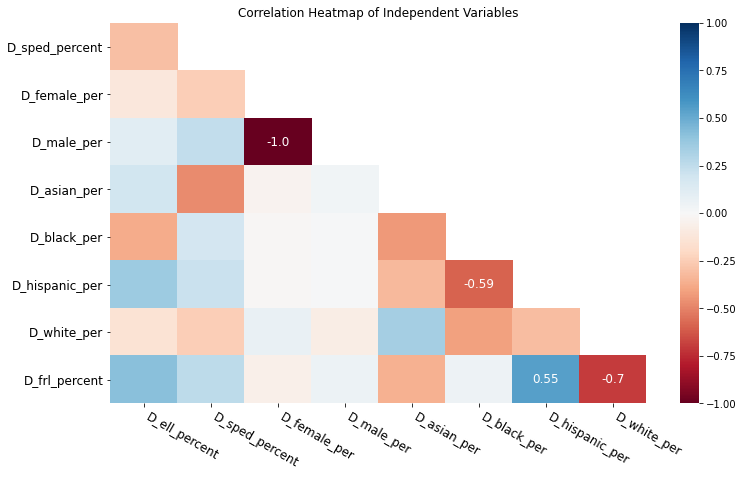

In [69]:
# Create a correlation matrix from X.
corr = X.corr()

# Create a mask that selects the bottom left triangle of the table.
corr = corr.iloc[1:, :-1]
mask = np.triu(         # Replace the lower triangle with 0's.
    np.ones_like(corr), # Make a DataFrame of 1's with the same shape as corr.
    k = 1,              # Raise the diagonal by 1.
)

# Plot a heatmap of the values.
plt.figure(figsize = (12, 7))

ax = sns.heatmap(
    corr,
    vmin = -1, # Anchor colors on -1 and 1.
    vmax = 1,
    cbar = True, # Draw a color bar.
    cmap = "RdBu", # Use Red for negatives and Blue for positives.
    mask = mask, # Use a mask to remove the upper right triangle of the matrix.
    annot = True, # Write the data value in each cell.
)

# Format the text in the plot to make it easier to read.
for text in ax.texts:
    coeff = float(text.get_text())
    
    # Remove data values with low correlation.
    if np.abs(coeff) < 0.5: 
        text.set_text('')
     # Round all visible data values to the hundredths place.
    else:
        text.set_text(round(coeff, 2))

    text.set_fontsize("large")
    
plt.title("Correlation Heatmap of Independent Variables")
    
# Rotate x-ticks to read from top to bottom.
plt.xticks(rotation = -30, ha = "left", size = "large") 
plt.yticks(rotation = 0, size = "large")

plt.show()

In the heatmap above, blue colors represent positive correlation; red represents negative correlation. Colors with more saturation indicate that the correlation is stronger.

I removed most of the coefficient labels except for the ones greater than 0.5. These have the strongest correlations. We can see that:

- Male percentage has a perfect negative correlation with female percentage. This is to be expected since both must sum up to 100.
- Hispanic percentage is correlated with black percentage and FRL percentage.
- White percentage is strongly negatively correlated with FRL percentage, indicating that schools with more white students also have fewer poor students.

Another way to assess multicollinearity is to use **variance inflation factors** or VIFs. These are numbers greater than or equal to 1.

A VIF less than 5 suggests low to moderate collinearity. If a predictor's VIF is at least 5, this indicates high multicollinearity, so the significance value is not reliable.

The code below produces a VIF for each predictor.

In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as sm_vif

def get_vif(X):

    """Get a VIF value for each column in a DataFrame."""
    
    vif_df = pd.DataFrame() 
    vif_df["label"] = X.columns
    vif_df["VIF"] = [
        sm_vif(X.values, i)
        for i in range(len(X.columns))
    ]
    vif_df.set_index("label", inplace = True)

    return vif_df

get_vif(X)

,VIF
label,
D_ell_percent,2.874752
D_sped_percent,8.509117
D_female_per,2578.305578
D_male_per,2569.217298
D_asian_per,304.520086
D_black_per,2196.055978
D_hispanic_per,2413.721821
D_white_per,231.186584
D_frl_percent,60.692762


These values are problematic. Almost all of the VIFs indicate strong multicollinearity, except for `D_ell_percent`. This is likely due to the strong correlations we saw earlier in the heatmap.

Therefore, we must remove a few variables with high multicollinearity. I did this by repeatedly removing variables from X and checking the VIFs until all variables had a VIF less than 5. I ended up removing:

- `D_male_per`
- `D_female_per`
- `D_sped_per`
- `D_frl_percent`

Thus, below is the new list of predictors. These cover the topics of **English proficiency** and **race**.

In [71]:
iv_list = [
    "D_ell_percent",
    "D_asian_per",
    "D_black_per",
    "D_hispanic_per",
    "D_white_per",
]

regression_data = (
    combined[["DBN", "R_sat_score"] + iv_list]
    .set_index("DBN")
)

X = regression_data[iv_list].copy()
y = regression_data["R_sat_score"].copy()

vif_df = get_vif(X)
vif_df

,VIF
label,
D_ell_percent,1.946933
D_asian_per,1.663056
D_black_per,1.483506
D_hispanic_per,2.343006
D_white_per,1.459861


We can see that the VIFs are all less than 5, so the p-values in the model will be reliable.

## IID Errors and Normality of Residuals

Next, we will be testing two more assumptions:

- IID (identically and independently distributed) residuals
    - This is tested using the [Durbin-Watson](https://www.statisticshowto.com/durbin-watson-test-coefficient/) test statistic, which ranges from 0 to 4.
    - Ideally, the statistic should be **close to 2**.
    - As a rule of thumb, values from 1.5 to 2.5 are considered acceptable.

- Normality of residuals
    - This is tested using the Jarque-Bera test.
    - The null hypothesis is that the residuals are normally distributed.
    - A statistically significant value **(p < 0.05)** supports the claim that the residuals are **not normal**.
    
In order to test these, we must fit the model and look at its results. `statsmodels` automatically calculates both the Durbin-Watson and the Jarque-Bera tests for us.

In [72]:
# OLS model

# Add a constant to the X matrix.
# This is done so that the y-intercept is not locked at 0.
X = sm.add_constant(X)

# Make and fit the OLS model.
model = sm.OLS(y, X)
results = model.fit()
summary = results.summary()

# Extract summary tables from OLS results summary.
def extract_summary(sm_summary):

    """Take a statsmodels summary instance and return a list of DataFrames."""

    tables = []
    t_inds = list(range(3))

    for i in t_inds:
        table_as_html = sm_summary.tables[i].as_html()

        table_df = pd.read_html(
            table_as_html,
            header = (0 if i == 1 else None), # Only set a header for table 2.
            index_col = 0,
        )[0]

        tables.append(table_df)

        if i == 1:
            # Combine summary table 1 with the VIF column.
            table_df = pd.concat([table_df, vif_df], axis = 1)
            table_df.rename_axis("label", inplace = True)

        else:
            # For tables 0 and 2, turn the index back into a column.
            table_df = tables[i].reset_index()

        tables[i] = table_df

    return tables

tables = extract_summary(summary)

# Display the third table.
tables[2]

,0,1,2,3
0,Omnibus:,60.404,Durbin-Watson:,1.629000e+00
1,Prob(Omnibus):,0.000,Jarque-Bera (JB):,1.287950e+02
2,Skew:,0.802,Prob(JB):,1.080000e-28
3,Kurtosis:,5.267,Cond. No.,6.090000e+03


The Durbin-Watson test statistic is 1.629. This is less than 2, so it indicates **positive autocorrelation** among residuals. (That is, each residual has a positive correlation with the residual before it). However, it falls within the acceptable range (1.5 to 2.5), so it is not a cause for concern.

The Jarque-Bera test significance, on the other hand, is $1.08 \cdot 10^{-28}$, which is very close to 0. It is statistically significant, so the residuals are **not normally distributed**. However, since the sample size (401) is greater than 30, OLS regression is robust against deviations from normality. Thus, this is not a cause for concern either.

Let's plot a **histogram of residuals** to inspect the deviation from normality, just to be sure.

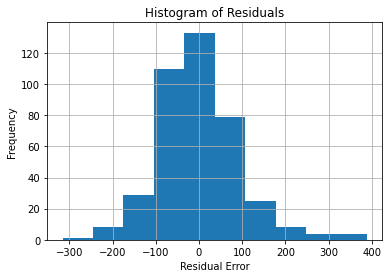

In [73]:
#%% Make a histogram of residuals.

residuals = results.resid
#bin_edges = get_bin_edges(residuals)

plt.hist(residuals, )#bins = bin_edges)
plt.title("Histogram of Residuals")
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.grid(True)

plt.show()

Though this isn't normal, it is still somewhat bell-shaped. Most of the data converges around a residual error of 0, with fewer values going farther away. Thus, the distribution isn't problematic.

We can also visualize normality of residuals using a Q-Q (quantile-quantile) plot.

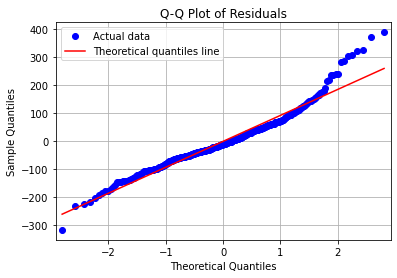

In [74]:
# Plot a Q-Q plot.

sm.qqplot(
    data = residuals,
    line = "r",
    # Regression line
)
plt.title("Q-Q Plot of Residuals")
plt.legend(
    labels = ["Actual data", "Theoretical quantiles line"],
    loc = "best",
)
plt.grid(True)

plt.show()

The red line is our reference for normality. The blue dots should ideally follow this line. We can see that they do, though not perfectly, and the data are less normal at the higher quantiles. Generally, though, the data is close enough to being normal.

Lastly, for IID residuals, we can plot the residuals against the fitted response variable.

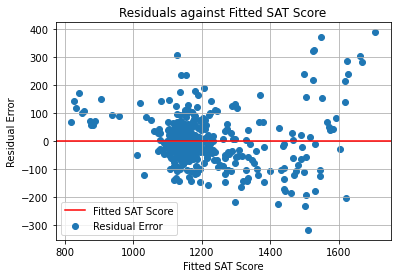

In [75]:
# Plot residuals against fitted DV values.

fitted = results.fittedvalues
residuals = results.resid

# Horizontal line on the x axis.
plt.axhline(color = "r", label = "Fitted SAT Score")

# Scatter plot.
plt.scatter(fitted, residuals, label = "Residual Error")

plt.title("Residuals against Fitted SAT Score")
plt.xlabel("Fitted SAT Score")
plt.ylabel("Residual Error")
plt.legend(loc = "best")
plt.grid(True)

plt.show()

In this graph, we ideally want to see the points cluster uniformly around the red line, without any trends. Though there are outliers, we can see that there are no trends, so the distribution of residual errors is fine. We saw earlier that the Durbin-Watson test statistic was within the acceptable range, so we can move on to the next step.

## Linearity

The next assumption that we will test is linearity. The predictors must be linearly correlated with the response variable; the relationship should not be too curved or abnormal.

We can test this visually by plotting the actual average SAT scores against the fitted scores which were predicted by our model.

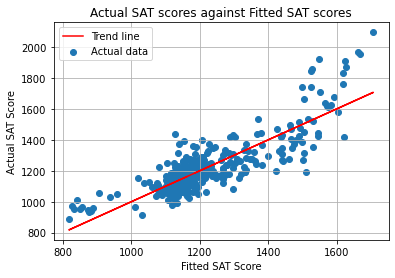

In [76]:
# Plot actual SAT scores against fitted SAT scores.

fitted = results.fittedvalues

# Scatter plot
plt.scatter(fitted, y, label = "Actual data")

# Use OLS model results to get trend line.

x_fitting = sm.add_constant(fitted)
trend_model = sm.OLS(y, x_fitting)
trend_results = trend_model.fit()

trend_params = trend_results.params
trend_const = trend_params["const"]
trend_coeff = trend_params[0]
y_plot = trend_coeff * fitted + trend_const

plt.plot(fitted, y_plot, color = "r", label = "Trend line")


# Extra plot info

plt.title("""Actual SAT scores against Fitted SAT scores""")
plt.xlabel("Fitted SAT Score")
plt.ylabel("Actual SAT Score")
plt.legend(loc = "best")
plt.grid(True)

plt.show()

The trend line above fits the actual data quite well. Moreover, the actual data seems to follow a mostly linear shape. Thus, there is no cause for concern here.

## Homoscedasticity

The last assumption that we will test is homoscedasticity. This means that the **variance** is consistent across all values of residuals. If this is not the case, the model has heteroscedasticity, which is problematic.

This can be tested using the Breusch-Pagan test. The null hypothesis is that heteroscedasticity is not present (which is ideal). A statistically significant p-value supports the claim that there is heteroscedasticity, in which case we would have to adjust the model.

In [77]:
# Breusch-Pagan test.

b_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
b_test = sms.het_breuschpagan(
    residuals,
    model.exog,
)

b_results = pd.DataFrame(zip(b_labels, b_test))
b_results.columns = ["Information", "Value"]

b_results

,Information,Value
0,Lagrange multiplier statistic,1.003550e+02
1,p-value,4.448703e-20
2,f-value,2.637012e+01
3,f p-value,5.319351e-23


Both p-values are very close to 0, which is significant. Thus, the model is **heteroscedastic**.

We can make the results robust against heteroscedasticity by specifying an HCCM (Heteroscedasticity Consistent Covariance Matrix). We will specifically choose HC0. It doesn't perform well for sample sizes under 250, but our sample size is 401, so we can use it.

In [78]:
# Make and fit the OLS model.
model = sm.OLS(y, X)
results = model.fit(
    cov_type = 'HC0', # Specify an HCCM.
)
summary = results.summary()
tables = extract_summary(summary)

Now that we've tested all of the assumptions and adjusted for heteroscedasticity, we can move on to partial regression plots.

## Partial regression plots

[Partial regression plots](https://www.statsmodels.org/devel/examples/notebooks/generated/regression_plots.html#Partial-Regression-Plots-(Duncan)) are used to visualize the relationship between 1 predictor and the response variable while **holding all other predictors constant**.

The plots are made below.

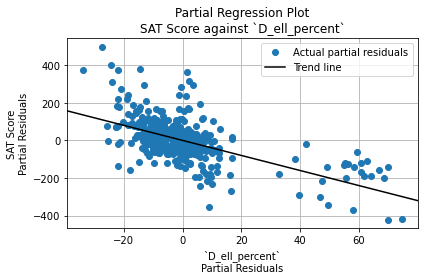

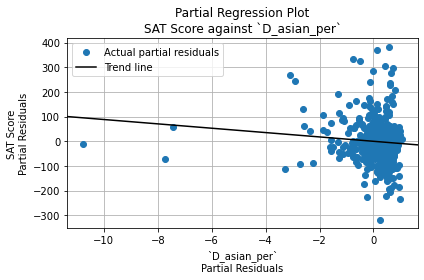

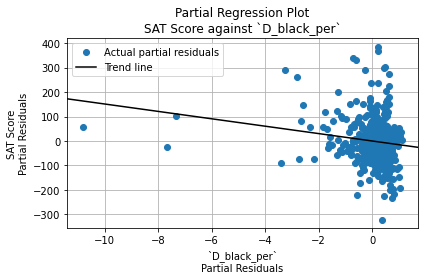

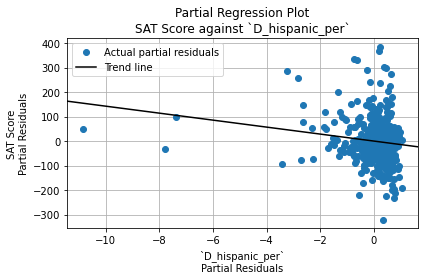

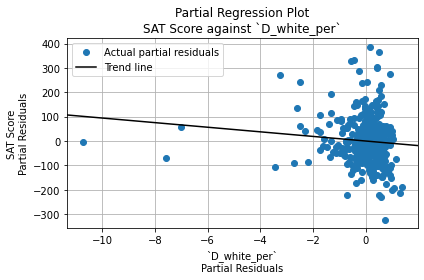

In [79]:
#%% Partial regression plots.
    
def par_reg_plot(data, label, show_dbn = False):
    
    """Take a predictor label and plot its partial regression plot, which takes the other predictors into account.
    Note: This function references objects from the global namespace."""
    
    title = "Partial Regression Plot\nSAT Score against `{}`".format(label)
    x_label = "`{}`\nPartial Residuals".format(label)
    
    # List of all IVs other than the current one.
    others = [col for col in iv_list if col != label]
    
    fig = sm.graphics.plot_partregress(
        endog = "R_sat_score",
        exog_i = label,
        exog_others = others,
        data = data,
        obs_labels = show_dbn,
    )
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel("SAT Score\nPartial Residuals")
    plt.grid(True)
    plt.legend(
        labels = ["Actual partial residuals", "Trend line"],
        loc = "best",
    )
    plt.tight_layout(
        h_pad = 2,
    )
    
    plt.show()
    
for label in iv_list:
    par_reg_plot(regression_data, label)

We can observe that:

- ELL percentage fits the trend line best.
- The other variables, which involve race, are affected by 3 outlier points.

We can identify which schools are the outliers by labeling the points.

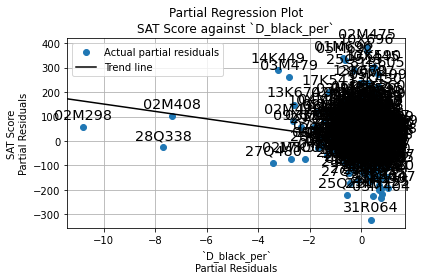

In [80]:
par_reg_plot(regression_data, "D_black_per", show_dbn = True)

The labels of the outliers are 02M298, 02M408, and 28Q338. These correspond to 3 rows in the dataset.

In [81]:
regression_data.loc[["02M298", "02M408", "28Q338"]]

,R_sat_score,D_ell_percent,D_asian_per,D_black_per,D_hispanic_per,D_white_per
DBN,,,,,,
02M298,1293.0,2.2,10.1,32.4,42.0,3.9
02M408,1522.0,2.0,7.0,19.1,23.7,41.8
28Q338,1178.0,2.0,2.4,61.4,17.5,10.0


Since these outliers are skewing our partial regression plots, we will drop them and fit the model again.

In [82]:
regression_data_new = regression_data.drop(
    ["02M298", "02M408", "28Q338"],
    axis = 0,
)

X_new = sm.add_constant(regression_data_new[iv_list].copy())
y_new = regression_data_new["R_sat_score"].copy()

model_new = sm.OLS(y_new, X_new)
results_new = model_new.fit(cov_type = 'HC0')
summary_new = results_new.summary()

tables_new = extract_summary(summary_new)

Below are the new partial regression plots.

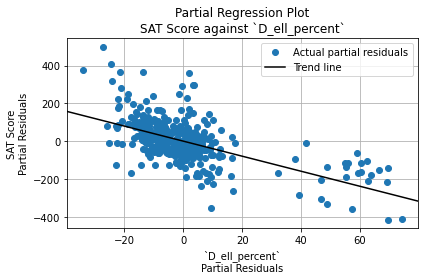

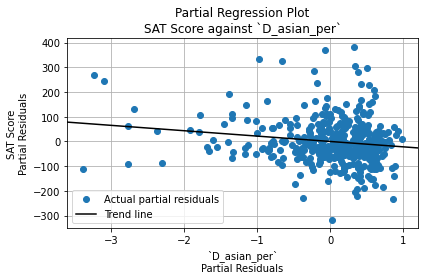

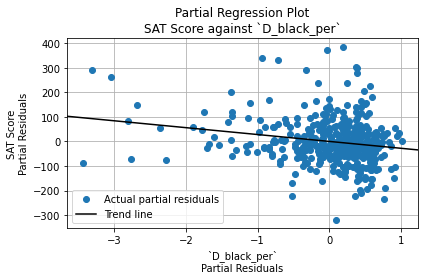

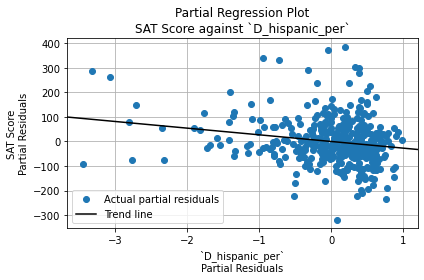

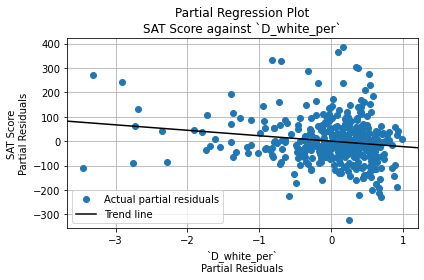

In [83]:
# New partial regression plots after dropping 3 outliers.

for label in iv_list:
    par_reg_plot(regression_data_new, label)

The data points now show trends which are closer to being linear, though still not that close. This is unavoidable since most of the data points have low SAT scores.

We can now interpret the model results.

## Interpretation of Results

In [84]:
tables_new[0]

,0,1,2,3
0,Dep. Variable:,R_sat_score,R-squared:,7.150000e-01
1,Model:,OLS,Adj. R-squared:,7.120000e-01
2,Method:,Least Squares,F-statistic:,6.793000e+01
3,Date:,"Sun, 13 Jun 2021",Prob (F-statistic):,5.070000e-51
4,Time:,11:49:12,Log-Likelihood:,-2.369300e+03
5,No. Observations:,398,AIC:,4.751000e+03
6,Df Residuals:,392,BIC:,4.775000e+03
7,Df Model:,5,NaN,NaN
8,Covariance Type:,HC0,NaN,NaN


Multiple regression analysis was used to test if a school's percentages of English Language Learners, Asian students, black students, hispanic students, and white students significantly predicted the school's average total SAT score.

The five predictors explained 71.5% of the variance (R2= 0.715, F(5, 392) = 67.93, p < 0.01).

In [85]:
tables_new[1]

,coef,std err,z,P>|z|,[0.025,0.975],VIF
label,,,,,,,
const,3900.9598,832.073,4.688,0.000,2270.127,5531.792,NaN
D_ell_percent,-3.9792,0.339,-11.726,0.000,-4.644,-3.314,1.946933
D_asian_per,-21.7416,8.393,-2.591,0.010,-38.191,-5.293,1.663056
D_black_per,-28.0245,8.401,-3.336,0.001,-44.490,-11.559,1.483506
D_hispanic_per,-27.1025,8.355,-3.244,0.001,-43.478,-10.726,2.343006
D_white_per,-22.3473,8.414,-2.656,0.008,-38.838,-5.856,1.459861


The predicted average SAT score in a school is approximately equal to 3901 - 4(ELL percentage) - 22(Asian percentage) - 28(black percentage) - 27(hispanic percentage) - 22(white percentage).

All of the independent variables used in the model were significant predictors of the school's average SAT score, with p < 0.05.

The coefficients for black and hispanic percentage were less than the coefficients for Asian and white percentage. This indicates that having a higher percentage of black and/or hispanic students in a school leads to lower average SAT scores. This supports the idea that SAT scores are influenced significantly by students' race.

# Conclusion

In this project, we cleaned, transformed, and combined multiple datasets about New York City high schools. We then conducted exploratory data analysis using Pearson's correlation coefficients and bivariate scatterplots.

Then, multiple linear regression was performed. The model explained 71.5% of the variance (R2= 0.715, F(5, 392) = 67.93, p < 0.01). This supports the claim that the percentage of each race in a school has an effect on the school's average SAT score.

Thanks for reading!